# Task 1: Data Preparation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# csv to dataframe 
df = pd.read_csv("A1data.csv")

In [3]:
# get data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ISO3                       90 non-null     object
 1   Countries and areas        90 non-null     object
 2   Region                     90 non-null     object
 3   Sub-region                 90 non-null     object
 4   Income Group               90 non-null     object
 5   Total                      90 non-null     object
 6   Residence (Rural)          85 non-null     object
 7   Residence (Urban)          86 non-null     object
 8   Wealth quintile (Poorest)  83 non-null     object
 9   Wealth quintile (Richest)  83 non-null     object
 10  Time period                90 non-null     object
dtypes: object(11)
memory usage: 7.9+ KB


In [4]:
#find duplicate rows
print(df[df.duplicated()])

   ISO3 Countries and areas Region Sub-region              Income Group Total  \
30  GTM           Guatemala    LAC        LAC  Upper middle income (UM)   10%   
75  TGO                Togo    SSA        WCA            Low income (L)   24%   
76  TGO                Togo    SSA        WCA            Low income (L)   24%   

   Residence (Rural) Residence (Urban) Wealth quintile (Poorest)  \
30                3%               20%                        0%   
75                8%               49%                        0%   
76                8%               49%                        0%   

   Wealth quintile (Richest) Time period  
30                       49%   2014-2015  
75                       78%        2017  
76                       78%        2017  


In [5]:
#drop duplicates
df.drop_duplicates(inplace=True)
print(df[df.duplicated()])

Empty DataFrame
Columns: [ISO3, Countries and areas, Region, Sub-region, Income Group, Total, Residence (Rural), Residence (Urban), Wealth quintile (Poorest), Wealth quintile (Richest), Time period]
Index: []


In [6]:
# convert percentage strings to float
df.iloc[:, 5:10] = df.iloc[:, 5:10].apply(lambda x: x.str.replace('%', '') if x.dtype == "object" else x)
df.iloc[:, 5:10] = df.iloc[:, 5:10].astype(float)    

In [7]:
# finding structural error
df["Income Group"].value_counts()

Income Group
Upper middle income (UM)     32
Lower middle income (LM)     28
Low income (L)               18
High income (H)               7
Lower middle income (LLM)     1
Lower middle income (LMM)     1
Name: count, dtype: int64

In [8]:
# replace with correct category
df["Income Group"] = df["Income Group"].replace({
    "Lower middle income (LLM)": "Lower middle income (LM)",
    "Lower middle income (LMM)": "Lower middle income (LM)"
})
df["Income Group"].value_counts()

Income Group
Upper middle income (UM)    32
Lower middle income (LM)    30
Low income (L)              18
High income (H)              7
Name: count, dtype: int64

In [9]:
# finding structural error
df["Time period"].value_counts()

Time period
2018         16
2018-2019     9
2019          9
2017          8
2013          6
2012          5
2017-2018     5
2015          4
2015-2016     4
2014-2015     3
2010          3
2014          3
2016          3
2011-2012     3
2016-2017     2
2076          1
3562          1
2011          1
2012-2099     1
Name: count, dtype: int64

In [10]:
# remove impossible time periods
df = df[(df["Time period"] != '3562') & (df["Time period"] != '2012-2099')]
df["Time period"].value_counts()

Time period
2018         16
2018-2019     9
2019          9
2017          8
2013          6
2017-2018     5
2012          5
2015-2016     4
2015          4
2016          3
2010          3
2014          3
2011-2012     3
2014-2015     3
2016-2017     2
2076          1
2011          1
Name: count, dtype: int64

In [11]:
# remove impossible percentages
df = df.drop(df[(df["Total"] < 0) | (df["Total"] > 100)].index)
df = df.drop(df[(df["Residence (Rural)"] < 0) | (df["Residence (Rural)"] > 100)].index)
df = df.drop(df[(df["Wealth quintile (Poorest)"] < 0) | (df["Wealth quintile (Poorest)"] > 100)].index)
df = df.drop(df[(df["Wealth quintile (Richest)"] < 0) | (df["Wealth quintile (Richest)"] > 100)].index)

df = df[df["Countries and areas"] != "Kenya"]

In [12]:
# columns with NaN values
df.isnull().sum()

ISO3                         0
Countries and areas          0
Region                       0
Sub-region                   0
Income Group                 0
Total                        0
Residence (Rural)            5
Residence (Urban)            4
Wealth quintile (Poorest)    7
Wealth quintile (Richest)    7
Time period                  0
dtype: int64

In [13]:
# get skewness values
print(df[["Residence (Rural)", "Residence (Urban)", "Wealth quintile (Poorest)", "Wealth quintile (Richest)"]].skew())

Residence (Rural)            1.004273
Residence (Urban)            0.280391
Wealth quintile (Poorest)    1.599889
Wealth quintile (Richest)   -0.490663
dtype: object


In [14]:
# get the mean values of each income group for columns with NaN values, round to one decimal 
income_group_means = df.groupby("Income Group")[["Residence (Rural)", "Residence (Urban)", "Wealth quintile (Richest)"]].transform(lambda x: round(x.median(), 1))

# median for Wealth quintile (Poorest) since skew is >1.5, round to one decimal 
income_group_medians = df.groupby("Income Group")[["Wealth quintile (Poorest)"]].transform(lambda x: round(x.median(), 1))

income_group_medians.head()

,Wealth quintile (Poorest)
0,21.0
1,1.0
2,21.0
3,21.0
4,1.0


In [15]:
# replace Nan values with means/medians of that income group for the column
df["Residence (Rural)"] = df["Residence (Rural)"].fillna(income_group_means["Residence (Rural)"])
df["Residence (Urban)"] = df["Residence (Urban)"].fillna(income_group_means["Residence (Urban)"])
df["Wealth quintile (Richest)"] = df["Wealth quintile (Richest)"].fillna(income_group_means["Wealth quintile (Richest)"])
df["Wealth quintile (Poorest)"] = df["Wealth quintile (Poorest)"].fillna(income_group_medians["Wealth quintile (Poorest)"])

In [16]:
df.isnull().sum()

ISO3                         0
Countries and areas          0
Region                       0
Sub-region                   0
Income Group                 0
Total                        0
Residence (Rural)            0
Residence (Urban)            0
Wealth quintile (Poorest)    0
Wealth quintile (Richest)    0
Time period                  0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 0 to 89
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ISO3                       83 non-null     object
 1   Countries and areas        83 non-null     object
 2   Region                     83 non-null     object
 3   Sub-region                 83 non-null     object
 4   Income Group               83 non-null     object
 5   Total                      83 non-null     object
 6   Residence (Rural)          83 non-null     object
 7   Residence (Urban)          83 non-null     object
 8   Wealth quintile (Poorest)  83 non-null     object
 9   Wealth quintile (Richest)  83 non-null     object
 10  Time period                83 non-null     object
dtypes: object(11)
memory usage: 7.8+ KB


In [18]:
#write to csv
df.to_csv("S3902159-cleaned-A1data.csv")
df

,ISO3,Countries and areas,Region,Sub-region,Income Group,Total,Residence (Rural),Residence (Urban),Wealth quintile (Poorest),Wealth quintile (Richest),Time period
0,DZA,Algeria,MENA,MENA,Upper middle income (UM),25.0,10.0,33.0,1.0,78.0,2018-2019
1,AGO,Angola,SSA,ESA,Lower middle income (LM),19.0,2.0,27.0,0.0,62.0,2015-2016
2,ARG,Argentina,LAC,LAC,Upper middle income (UM),43.0,44.0,58.0,21.0,91.0,2011-2012
3,ARM,Armenia,ECA,EECA,Upper middle income (UM),81.0,71.0,89.0,44.0,99.0,2015-2016
4,BGD,Bangladesh,SA,SA,Lower middle income (LM),34.0,31.0,48.0,8.0,73.0,2019
...,...,...,...,...,...,...,...,...,...,...,...
84,GBR,United Kingdom,ECA,WE,High income (H),99.0,66.0,69.0,20.0,93.0,2016
86,UZB,Uzbekistan,ECA,EECA,Lower middle income (LM),18.0,14.0,31.0,1.0,70.0,2017
87,VNM,Viet Nam,EAP,EAP,Lower middle income (LM),45.0,17.0,62.0,11.0,82.0,2012
88,ZMB,Zambia,SSA,ESA,Lower middle income (LM),8.0,2.0,16.0,0.0,31.0,2018-2019


# Task 2: Data Exploration

In [19]:
# cleaned csv to dataframe 
cleaned_df = pd.read_csv("S3902159-cleaned-A1data.csv")

In [20]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 83 non-null     int64  
 1   ISO3                       83 non-null     object 
 2   Countries and areas        83 non-null     object 
 3   Region                     83 non-null     object 
 4   Sub-region                 83 non-null     object 
 5   Income Group               83 non-null     object 
 6   Total                      83 non-null     float64
 7   Residence (Rural)          83 non-null     float64
 8   Residence (Urban)          83 non-null     float64
 9   Wealth quintile (Poorest)  83 non-null     float64
 10  Wealth quintile (Richest)  83 non-null     float64
 11  Time period                83 non-null     object 
dtypes: float64(5), int64(1), object(6)
memory usage: 7.9+ KB


## Task 2.1 

In [21]:
# group Total by Region with median
median_total_by_region = cleaned_df.groupby("Region")["Total"].median()
print(median_total_by_region)

Region
EAP     47.5
ECA     77.5
LAC     43.0
MENA    33.0
SA      39.0
SSA      6.5
Name: Total, dtype: float64


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Median Total Percentage of Children with Internet at Home')

Text(0.5, 0, 'Region')

Text(0, 0.5, 'Total Percentage')

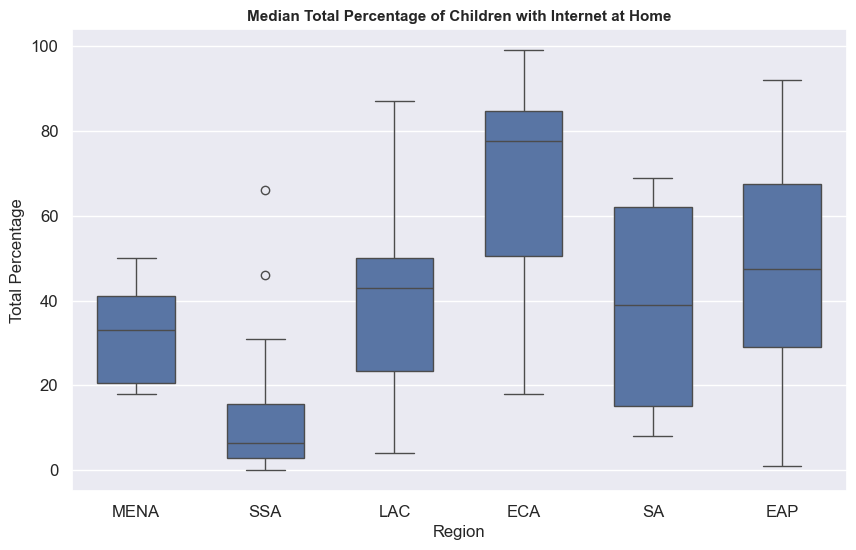

In [22]:
# make boxplot
sns.set_theme(style="darkgrid")
 
plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
median_total_boxplot = sns.boxplot(x="Region", y="Total", data=cleaned_df, width=0.6)

# title and text sizes
median_total_boxplot.set_title("Median Total Percentage of Children with Internet at Home", fontsize=11, fontweight='bold')
median_total_boxplot.set_xlabel("Region", fontsize=12)
median_total_boxplot.set_ylabel("Total Percentage", fontsize=12)
median_total_boxplot.tick_params(axis='x', labelsize=12)  
median_total_boxplot.tick_params(axis='y', labelsize=12)  

# show boxplot
plt.show()

## Task 2.2 

In [23]:
# mean for Wealth quintile (Poorest) and Wealth quintile (Richest)
mean_poorest = cleaned_df["Wealth quintile (Poorest)"].mean()
mean_richest = cleaned_df["Wealth quintile (Richest)"].mean()

print(f"Wealth quintile (Poorest) Mean: {mean_poorest}")
print(f"Wealth quintile (Poorest) Mean: {mean_richest}")

Wealth quintile (Poorest) Mean: 16.89156626506024
Wealth quintile (Poorest) Mean: 62.04819277108434


In [24]:
# sort top 10 Wealth quintile (Poorest) and Wealth quintile (Richest) by Countries
top_poorest = df.sort_values(by="Wealth quintile (Poorest)", ascending=False).head(10)
top_richest = df.sort_values(by="Wealth quintile (Richest)", ascending=False).head(10)

# show relevant columns for each df
top_poorest[["Countries and areas", "Wealth quintile (Poorest)"]]
top_richest[["Countries and areas","Wealth quintile (Richest)"]]

,Countries and areas,Wealth quintile (Poorest)
65,Somalia,100.0
9,Brazil,84.0
77,Tonga,83.0
15,Chile,75.0
68,Sri Lanka,71.0
73,North Macedonia,68.0
63,Serbia,65.0
36,Japan,64.0
40,Kyrgyzstan,56.0
49,Montenegro,55.0


,Countries and areas,Wealth quintile (Richest)
10,Bulgaria,100.0
63,Serbia,100.0
65,Somalia,100.0
5,Barbados,100.0
73,North Macedonia,100.0
18,Costa Rica,99.0
15,Chile,99.0
17,Colombia,99.0
27,Georgia,99.0
68,Sri Lanka,99.0


## Task 2.3 

In [25]:
# Code goes after this line by adding cells
